# Please look at the following files for implementation:

* Directory: gridworld_env/gridworld.py
* Directory: gridworld_env/__init__.py
* custom_actor_critic.py
* ECE 590 Deep RL | HW2.ipynb

In [1]:
%matplotlib inline

import argparse
import sys
from tqdm import trange

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(precision=4)

import gym
from gym import wrappers, logger
from gridworld_env import gridworld

from spinup.utils.mpi_tools import mpi_fork, mpi_avg, proc_id, mpi_statistics_scalar, num_procs
from agents import RandomAgent

import torch

# Problem 1 (a)-(c)

##### Solution: Please see the code in the directory - gridworld_env.py. 

Note that to use the constructor of the custom environment with the official `gym.make` function, we need to first register the environment. Please see the `gridworld_env/__init__.py` on how to register the environment. The constructor of the GridWorld takes the reward matrix via kwargs dictionary defined in `__init__.py`. The environment defined in Example 3.5 (Sutton and Barto) is defined with the environment-id: `GridWorld-v0`. A brief summary of the GridWorld class is as follows:

    Description:
        Gridworld environment as specified in Sutton and Barto (Example 3.5)
    Observation: 
        Discrete (width*height)
    Actions:
        Discrete (4)
        North, South, West, East
    Reward:
        Reward as specified in Example 3.5 of Sutton et al.
        The reward matrix is specified in __init__.py
    Starting State:
        Starting state is a location on the grid
    Episode Termination:
        Episode terminates after MAX_STEPS_PER_EPISODE


# Problem 1 (d)

##### Solution: The custom environment is working and meets the required specification as we will see below when we estimate the state-value function using a random agent.


# Problem 1 (e)

##### Solution: The environment  `GridWorld-v0` corresponds to Example 3.5 (Sutton and Barto). 
##### Please see the definition in `gridworld_env/__init__.py`.

# Problem 2 (a)-(b)

In [2]:
env_id = 'GridWorld-v0'
seed = 1234

In [3]:
env = gym.make(env_id)
env.seed(seed)
agent = RandomAgent(env.action_space)
num_episodes = 20000
reward = 0.
done = False

In [4]:
alpha = 0.01
gamma = 0.9

In [5]:
V = np.zeros((env.h, env.w))
for episode in trange(1, num_episodes+1):
    ob = env.reset()
    s_old = env.position
    rewards = []
    while True:
        action = agent.act(ob, reward, done)
        ob, reward, done, _ = env.step(action)
        s_new = env.position
        
        V[s_old[0], s_old[1]] = V[s_old[0], s_old[1]] + alpha*(reward + gamma*V[s_new[0], s_new[1]] - V[s_old[0], s_old[1]]) 
        rewards.append(reward)
        if done:
            break

        s_old = s_new
        # Note there's no env.render() here. But the environment still can open window and
        # render if asked by env.monitor: it calls env.render('rgb_array') to record video.
        # Video is not recorded every episode, see capped_cubic_video_schedule for details.
    
    if episode % 5000 == 0:
        print ('Episode Number: {:d} | Total Reward: {:.4f} '.format(episode, np.sum(rewards)))

# Close the env and write monitor result info to disk
env.close()

 27%|██▋       | 5346/20000 [00:02<00:06, 2326.83it/s]

Episode Number: 5000 | Total Reward: 8.0000 


 51%|█████▏    | 10266/20000 [00:04<00:04, 2396.07it/s]

Episode Number: 10000 | Total Reward: 18.0000 


 77%|███████▋  | 15394/20000 [00:06<00:01, 2423.14it/s]

Episode Number: 15000 | Total Reward: 3.0000 


100%|██████████| 20000/20000 [00:08<00:00, 2427.41it/s]

Episode Number: 20000 | Total Reward: -6.0000 


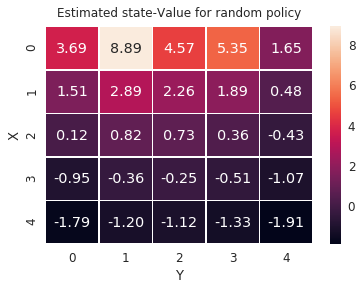

In [6]:
sns.set(font_scale = 1.2)
ax = sns.heatmap(V, annot=True, fmt=".2f", linewidths=.5)
ax.set_title('Estimated state-Value for random policy', pad=10, fontsize=12)

# We use the convention followed by numpy, 
# i.e. top-left is (0,0) and x is along the hieght of the grid

ax.set_ylabel('X') # X corresponds to the first dimension
ax.set_xlabel('Y') # Y corresponds to the second dimension
plt.show()

# VPG

## Problem 3 (a)

##### Solution: Trajectory length is set to 20: See the GridWorld class defined in gridworld_env/gridworld.py file

## Problem 3 (b)

##### Solution: I had to adapt the VPG code and actor-critic code to make the discrete space work. In particular, following files were adapted/modified from the original spinningup code:
* vpg.py (env.obs.shape[0] -> env.obs.n) + Return total reward for plotting.
* custom_actor_critic.py (line 15: observation_sapce.shape[0] -> observation_space.n)

In [7]:
from spinup.utils.run_utils import setup_logger_kwargs
logger_kwargs = setup_logger_kwargs('vpg', seed, data_dir='model/')

# The following two files were adapted to make
# discrete observation space work with vpg.
from custom_actor_critic import MLPActorCritic
from vpg import vpg as vpg_pytorch

In [8]:
hid = 32
num_layers = 2
gamma = 0.9
num_epochs = 2000
cpu = 2

MAX_STEPS_PER_EPISODE = gridworld.GridWorld.MAX_STEPS_PER_EPISODE
steps = MAX_STEPS_PER_EPISODE

In [9]:
epoch_reward = vpg_pytorch(lambda : gym.make(env_id), actor_critic=MLPActorCritic,
                            ac_kwargs=dict(hidden_sizes=[hid]*num_layers), gamma=gamma, 
                            seed=seed, steps_per_epoch=steps, epochs=num_epochs,
                            logger_kwargs=logger_kwargs, max_ep_len=MAX_STEPS_PER_EPISODE)


Logging data to model/vpg/vpg_s1234/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            32,
            32
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "env_fn":	"<function <lambda> at 0x7f2dec2dc9e0>",
    "epochs":	2000,
    "exp_name":	"vpg",
    "gamma":	0.9,
    "lam":	0.97,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f2dec29b810>":	{
            "epoch_dict":	{},
            "exp_name":	"vpg",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"model/vpg/vpg_s1234",
            "output_file":	{
                "<_io.TextIOWrapper name='model/vpg/vpg_s1234/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
            }
        }
    },
    "logger_kwargs":	{
        "exp_name":	"vpg",
        "output_dir":	"model/vpg/vpg_s1234"
    },
    "max_ep_len":	20,
    "pi_lr":	0.0003,
    "save_freq"

## Problem 3 (c)

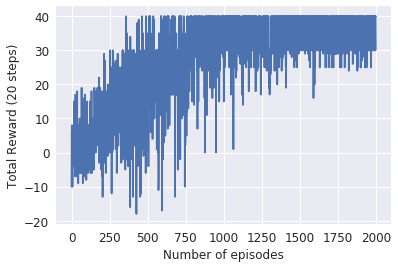

In [10]:
plt.plot(epoch_reward)
plt.ylabel('Total Reward (20 steps)', fontsize=12)
plt.xlabel('Number of episodes', fontsize=12)
plt.show()

## Problem 3 (d)

In [11]:
ac = torch.load('model/vpg/vpg_s1234/pyt_save/model.pt')

In [12]:
dummy_env = gym.make(env_id)
all_obs = dummy_env.all_state

In [13]:
with torch.no_grad():
    value = ac.v(torch.as_tensor(all_obs, dtype=torch.float32))
V = np.reshape(value.numpy(), (dummy_env.h, dummy_env.w))

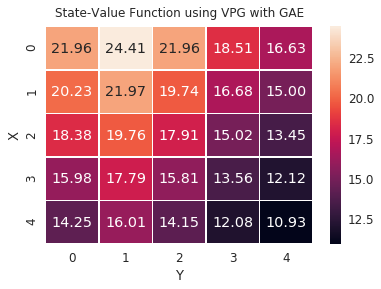

In [14]:
sns.set(font_scale = 1.2)
ax = sns.heatmap(V, annot=True, fmt=".2f", linewidths=.5)
ax.set_title('State-Value Function using VPG with GAE', pad=10, fontsize=12)

# We use the convention followed by numpy, 
# i.e. top-left is (0,0) and x is along the hieght of the grid

ax.set_ylabel('X') # X corresponds to the first dimension
ax.set_xlabel('Y') # Y corresponds to the second dimension
plt.show()